In [ ]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from wordcloud import WordCloud

In [ ]:
# data from:
# https://www.kaggle.com/uciml/sms-spam-collection-dataset
!wget https://lazyprogrammer.me/course_files/spam.csv

--2024-09-14 16:51:25--  https://lazyprogrammer.me/course_files/spam.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 172.67.213.166, 104.21.23.210, 2606:4700:3031::6815:17d2, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|172.67.213.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 503663 (492K) [text/csv]
Saving to: ‘spam.csv’

spam.csv            100%[===================>] 491.86K  --.-KB/s    in 0.1s    

2024-09-14 16:51:26 (4.28 MB/s) - ‘spam.csv’ saved [503663/503663]



# New Section

In [ ]:
# file contains some invalid chars
# depending on which version of pandas you have
# an error may be thrown
df = pd.read_csv('/content/spam.csv', encoding='ISO-8859-1')

In [ ]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [ ]:
# drop unnecessary columns
df = df.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)

In [ ]:
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
# rename columns to something better
df.columns = ['labels', 'data']

In [ ]:
df.head()

,labels,data
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


<Axes: >

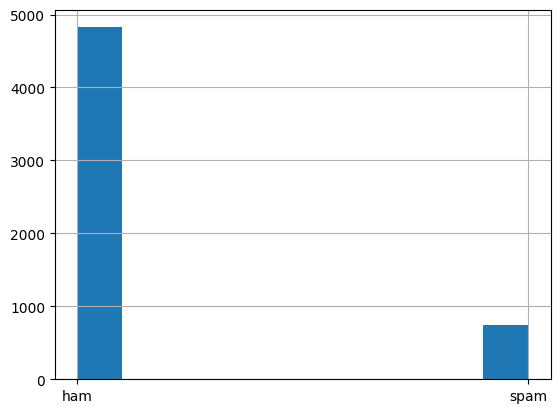

In [ ]:
df['labels'].hist()

In [ ]:
# create binary labels
df['b_labels'] = df['labels'].map({'ham': 0, 'spam': 1})
Y = df['b_labels'].to_numpy()

In [ ]:
# split up the data
df_train, df_test, Ytrain, Ytest = train_test_split(
    df['data'], Y, test_size=0.33)

In [ ]:
# try multiple ways of calculating features

featurizer =CountVectorizer(decode_error='ignore')
Xtrain = featurizer.fit_transform(df_train)
Xtest = featurizer.transform(df_test)

In [ ]:
Xtrain

<3733x7023 sparse matrix of type '<class 'numpy.int64'>'
	with 49516 stored elements in Compressed Sparse Row format>

In [ ]:
# create the model, train it, print scores
model = MultinomialNB()
model.fit(Xtrain, Ytrain)
print("train acc:", model.score(Xtrain, Ytrain))
print("test acc:", model.score(Xtest, Ytest))

train acc: 0.993838735601393
test acc: 0.9864056552474171


In [ ]:
#check the accuracy,calculate and print
#print the f1 score of the model on the training data
#print the f1 score of the model on the test data
#assign the predicted probability of training data to the variable 'Prob_train'
#assign the predicted probability of test data to the variable 'Prob_test'
Ptrain = model.predict(Xtrain)
Ptest = model.predict(Xtest)
print("train F1:", f1_score(Ytrain, Ptrain))
print("test F1:", f1_score(Ytest, Ptest))

train F1: 0.9772951628825272
test F1: 0.945054945054945


In [ ]:
Prob_train = model.predict_proba(Xtrain)[:,1]
Prob_test = model.predict_proba(Xtest)[:,1]
print("train AUC:", roc_auc_score(Ytrain, Prob_train))
print("test AUC:", roc_auc_score(Ytest, Prob_test))

train AUC: 0.9904343495514836
test AUC: 0.9899598608223453


In [ ]:
#to calculate confusion matrix
cm = confusion_matrix(Ytrain, Ptrain)
cm

array([[3215,    4],
       [  19,  495]])

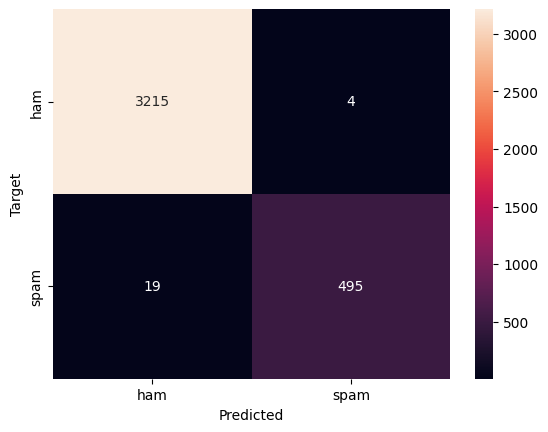

In [ ]:
# The changes modify how confusion matrices are plotted
#line calls a function 'plot_cm' to show the heatmap of the confusion matrix of the model on the training data
#next line assigns the confusion matrix of the model on the test data to the variable 'cm_test'
#next line calls the 'plot_cm' function to show the heatmap of the confusion matrix
def plot_cm(cm):
  classes = ['ham', 'spam']
  df_cm = pd.DataFrame(cm, index=classes, columns=classes)
  ax = sn.heatmap(df_cm, annot=True, fmt='g')
  ax.set_xlabel("Predicted")
  ax.set_ylabel("Target")

plot_cm(cm)

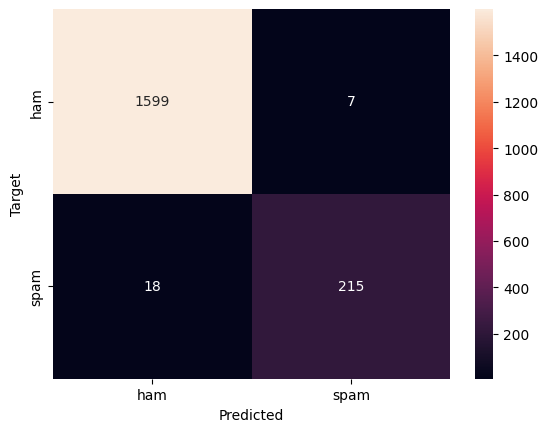

In [ ]:
cm_test = confusion_matrix(Ytest, Ptest)
plot_cm(cm_test)

In [ ]:
# visualize the data
def visualize(label):
  words = ''
  for msg in df[df['labels'] == label]['data']:
    msg = msg.lower()
    words += msg + ' '
  wordcloud = WordCloud(width=600, height=400).generate(words)
  plt.imshow(wordcloud)
  plt.axis('off')
  plt.show()

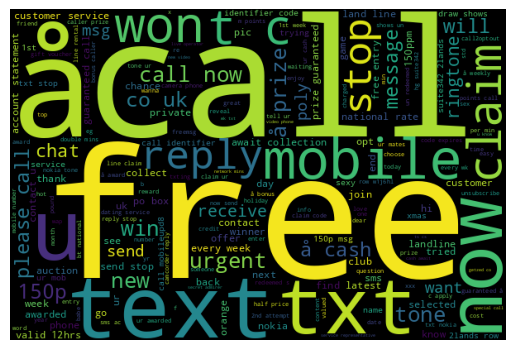

In [ ]:
visualize('spam')

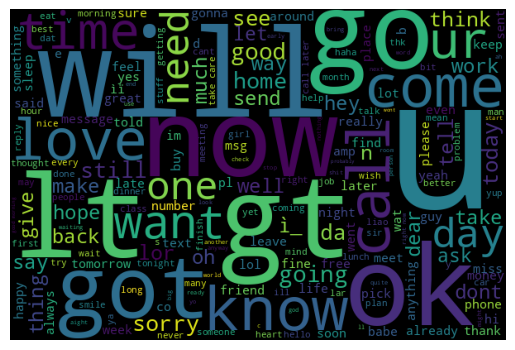

In [ ]:
visualize('ham')

In [ ]:
# see what we're getting wrong
X = featurizer.transform(df['data'])
df['predictions'] = model.predict(X)

In [ ]:
# things that should be spam
sneaky_spam = df[(df['predictions'] == 0) & (df['b_labels'] == 1)]['data']
for msg in sneaky_spam:
  print(msg)

FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, å£1.50 to rcv
Did you hear about the new \Divorce Barbie\"? It comes with all of Ken's stuff!"
Do you realize that in about 40 years, we'll have thousands of old ladies running around with tattoos?
Talk sexy!! Make new friends or fall in love in the worlds most discreet text dating service. Just text VIP to 83110 and see who you could meet.
Hello. We need some posh birds and chaps to user trial prods for champneys. Can i put you down? I need your address and dob asap. Ta r
Dont forget you can place as many FREE Requests with 1stchoice.co.uk as you wish. For more Information call 08707808226.
Please CALL 08712402779 immediately as there is an urgent message waiting for you
Can U get 2 phone NOW? I wanna chat 2 set up meet Call me NOW on 09096102316 U can cum here 2moro Luv JANE xx Callså£1/minmoremobsEMSPOBox45PO139WA
SMS. ac JSco: Energy is high, but u 

In [ ]:
# things that should not be spam
# perhaps some are mislabeled?
not_actually_spam = df[(df['predictions'] == 1) & (df['b_labels'] == 0)]['data']
for msg in not_actually_spam:
  print(msg)

We have sent JD for Customer Service cum Accounts Executive to ur mail id, For details contact us
Hey...Great deal...Farm tour 9am to 5pm $95/pax, $50 deposit by 16 May
Yavnt tried yet and never played original either
Unlimited texts. Limited minutes.
Mathews or tait or edwards or anderson
Gettin rdy to ship comp
Have you laid your airtel line to rest?
I liked the new mobile
Anytime...
Nokia phone is lovly..
We have sent JD for Customer Service cum Accounts Executive to ur mail id, For details contact us
